**Defining the Research Questions**

1. How have precipitation levels in San Francisco changed from 1920 to 2023, and what can we predict for these variables in the year 2050?
2. Can the model we develop capture and predict an increase in extreme weather events, such as a 100-year flood?


**Understanding the Machine Learning Problem**

The type of machine learning problem we are investigating is an univariate time series forecasting model with a continuous variable (daily precipitation.) Climate change's impact on precipitation has special features that make it hard to model - its impact is stochastic and slowly transmits its impact in the long term, more than 20 years.



**Import libraries**

In [4]:
!pip install --upgrade pandas

In [7]:
# import libraries
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip show tensorflow
#!pip install --user tensorflow
#!pip install tensorflow==2.13.1
#!pip install --upgrade scikit-learn
#!pip install keras==2.12.1
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
#from tensorflow.keras.losses import categorical_crossentropy
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor



**Import datasets**

1) Import data from San Francisco's weather stations and merge them togerther

In [7]:
sf_daily


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES
0,US1CASF0003,2009-01-24,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",64.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN
1,US1CASF0003,2009-02-02,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",NaN,NaN,NaN,NaN
2,US1CASF0003,2009-02-04,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",NaN,NaN,NaN,NaN
3,US1CASF0003,2009-02-05,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",33.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN
4,US1CASF0003,2009-02-06,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",84.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,US1CASF0003,2016-07-07,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",NaN,NaN,NaN,NaN
1021,US1CASF0003,2016-07-08,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,"T,,N",NaN,NaN,NaN,NaN,NaN,NaN
1022,US1CASF0003,2016-07-11,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",NaN,NaN,NaN,NaN
1023,US1CASF0003,2016-08-05,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,"T,,N",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(type(sf_daily))

<class 'pandas.core.frame.DataFrame'>


In [9]:
import pandas as pd

# Define the path to your CSV files
file_list = [
    'data/US1CASF0003.csv', 'data/US1CASF0004.csv', 'data/US1CASF0008.csv', 'data/US1CASF0014.csv',
    'data/US1CASF0017.csv', 'data/US1CASF0020.csv', 'data/US1CASF0021.csv',
    'data/USC00047765.csv', 'data/USC00047767.csv', 'data/USW00023234.csv',
    'data/USW00023272.csv'
]

# Initialize an empty list to store DataFrames
dfs = []

# Read the first CSV file separately to initialize the sf_daily DataFrame
sf_daily = pd.read_csv(file_list[0])

# Loop through the list of files (starting from the second file) and append them to dfs
for filename in file_list[1:]:
    # Read the CSV file into a temporary DataFrame
    temp = pd.read_csv(filename)
    # Append the new data to the list of DataFrames
    dfs.append(temp)

# Concatenate the list of DataFrames into a single DataFrame
sf_daily = pd.concat([sf_daily] + dfs, ignore_index=True)

# Convert column names to lowercase
sf_daily.columns = sf_daily.columns.str.lower()

# Convert the 'date' column to datetime
sf_daily['date'] = pd.to_datetime(sf_daily['date'], format="%Y-%m-%d")

# Sort the DataFrame by date
#sf_daily = sf_daily.sort_values(by='date')

# Reset the index
sf_daily.reset_index(drop=True, inplace=True)

sf_daily


C:\Users\jeng_\AppData\Local\Temp\ipykernel_4884\349634030.py:20: DtypeWarning: Columns (11,17,19,21,23,25,27,29,31,33,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,75,79,83,85,87,89,91,95,97,99,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_4884\349634030.py:20: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(filename)


,station,date,latitude,longitude,elevation,name,prcp,prcp_attributes,snow,snow_attributes,...,wt21,wt21_attributes,wv01,wv01_attributes,wv03,wv03_attributes,wv20,wv20_attributes,psun,psun_attributes
0,US1CASF0003,2009-01-24,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",64.0,",,N",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1CASF0003,2009-02-02,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1CASF0003,2009-02-04,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",0.0,",,N",0.0,",,N",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1CASF0003,2009-02-05,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",33.0,",,N",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1CASF0003,2009-02-06,37.7834,-122.4701,52.7,"SAN FRANCISCO 2.8 WNW, CA US",84.0,",,N",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101847,USW00023272,2023-10-14,37.7705,-122.4269,45.7,"SAN FRANCISCO DOWNTOWN, CA US",0.0,",,W,2400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101848,USW00023272,2023-10-15,37.7705,-122.4269,45.7,"SAN FRANCISCO DOWNTOWN, CA US",0.0,",,W,2400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101849,USW00023272,2023-10-16,37.7705,-122.4269,45.7,"SAN FRANCISCO DOWNTOWN, CA US",0.0,",,W,2400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101850,USW00023272,2023-10-18,37.7705,-122.4269,45.7,"SAN FRANCISCO DOWNTOWN, CA US",0.0,",,W,2400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Import data from San Francisco's weather stations and merge them togerther

# Define the path to your CSV file
file_list =[r'data/US1CASF0004.csv', r'data/US1CASF0008.csv', r'data/US1CASF0014.csv', \
            r'data/US1CASF0017.csv', r'data/US1CASF0020.csv', r'data/US1CASF0021.csv', r'data/USC00047765.csv', \
            r'data/USC00047767.csv', r'data/USW00023234.csv', r'data/USW00023272.csv']  
sf_daily = pd.read_csv('data/US1CASF0003.csv')
for filename in file_list:
        # Read the CSV file into a new DataFrame
        temp = pd.read_csv(filename)
        # Append the new data to the existing DataFrame
        sf_daily = sf_daily.append(temp, ignore_index=True)

#lower case series name
sf_daily.columns = sf_daily.columns.str.lower()

# Convert the 'date' column to datetime
sf_daily['date'] = pd.to_datetime(sf_daily['date'], format="%Y-%m-%d")

# Set the 'year' column as the index
# sf_daily.set_index('date', inplace=True)
sf_daily


AttributeError: 'DataFrame' object has no attribute 'append'

2) Import Green House gases concentraltion

In [10]:
# import green house gases concentration from excel
file_path = r'data/ghg_concentration.xlsx'

# Read the Excel file into a pandas DataFrame
rcp = pd.read_excel(file_path)

# Convert the 'rcp' column to datetime
rcp['year'] = pd.to_datetime(rcp['year'], format='%Y')

# Set the 'year' column as the index
# rcp.set_index('year', inplace=True)
rcp

,year,rcp45,rcp85
0,1765-01-01,277.01467,277.01467
1,1766-01-01,277.83880,277.83880
2,1767-01-01,278.69351,278.69351
3,1768-01-01,278.74752,278.74752
4,1769-01-01,278.79644,278.79644
...,...,...,...
331,2096-01-01,579.08959,1175.09150
332,2097-01-01,579.55387,1189.21720
333,2098-01-01,580.01489,1203.35310
334,2099-01-01,580.46977,1217.48310


**EDA**

**check data sanity**
Check missing data, data avaiability, and fill the missing data in bot datasets
1) climate data from weather stations in SF.
2) World's GHGs concentration. 



In [11]:
#Check missing value, there many variable with most of records are missing value
missing_values = sf_daily.isna().sum()
missing_values = missing_values.reset_index()  # Reset the index to make it a DataFrame
missing_values.columns = ['Variables', 'Missing Values']  # Rename the columns
specific_vars = ['station', 'date', 'latitude', 'longitude', 'elevation', 'name', 'prcp',
                 'prcp_attributes', 'snow', 'snow_attributes', 'snwd', 'tmax', 'tmin']

# Filter the DataFrame based on the specific variables 
filtered_missing_values_sf = missing_values.loc[missing_values['Variables'].isin(specific_vars)]

print(filtered_missing_values_sf)


          Variables  Missing Values
0           station               0
1              date               0
2          latitude               0
3         longitude               0
4         elevation               0
5              name               0
6              prcp            1716
7   prcp_attributes            1716
8              snow           34662
9   snow_attributes           34662
16             snwd           42917
18             tmax           13072
20             tmin           13187


In [12]:
# check data avaiability in each station

grouped = sf_daily.groupby(['station']).agg('count')

# Transpose the table using .T
transposed_table = grouped.T

# Alternatively, you can use the .transpose() method
# transposed_table = grouped.transpose()

# Now, transposed_table contains the transposed version of the grouped DataFrame
print(transposed_table.loc[['date', 'prcp', 'snow', 'snwd', 'tmax', 'tmin']])

station  US1CASF0003  US1CASF0004  US1CASF0008  US1CASF0014  US1CASF0017  \
date            1025         4979         1461          162         1169   
prcp            1024         4979         1459          153         1158   
snow             582         3900         1121            0          905   
snwd               0            0            0            0            0   
tmax               0            0            0            0            0   
tmin               0            0            0            0            0   

station  US1CASF0020  US1CASF0021  USC00047765  USC00047767  USW00023234  \
date             764          482         2185        23517        28564   
prcp             760          482         2178        21849        28562   
snow             464          297         2185        17895        18773   
snwd               0            0         2184        17679        17837   
tmax               0            0         2152        20556        28543   
tmin       

In [13]:
# I select station 'USW00023272' to build the model becuase it is the one that has the least missing value
# Then indentify missing value 
station_code = 'USW00023272'
missing_indices = sf_daily.loc[
    (sf_daily['station'] == station_code) &
    (sf_daily['prcp'].isnull() | sf_daily['tmax'].isnull() | sf_daily['tmin'].isnull())
].index

missing_indices

Index([ 84328,  84329,  84343,  84344,  85476,  85477,  85478,  85549,  85550,
        85903,  85904,  92023,  92024, 101839, 101840, 101841, 101842, 101843,
       101844, 101845, 101846, 101847, 101848, 101849, 101850, 101851],
      dtype='int64')

In [14]:
# Assuming sf_daily is your DataFrame

# because the missing value is a few, I use linear interpolation to fill them 
station_code = 'USW00023272'
sf_daily_station = sf_daily.loc[sf_daily['station'] == station_code]

# List to store the interpolated series
interpolated_series = []

# Iterate over each column except 'date'
for column in sf_daily_station.columns[1:]:
    # Linear interpolation for each series
    interpolated_series.append(sf_daily_station[column].interpolate(method='linear'))

# Combine the interpolated series into a new DataFrame
sf_daily_filled = pd.DataFrame(interpolated_series).transpose()

# Add the 'date' column to the new DataFrame
sf_daily_filled['date'] = sf_daily_station['date']

# Reorder columns
sf_daily_filled = sf_daily_filled[['date'] + list(sf_daily_station.columns[1:])]

# select 4 main variables in the dataset
main4 = sf_daily_filled[['date', 'prcp', 'snow', 'tmax', 'tmin']]


C:\Users\jeng_\AppData\Local\Temp\ipykernel_4884\2936643540.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_series.append(sf_daily_station[column].interpolate(method='linear'))


In [44]:
# because the missing value is a few, I use linear interpolation to fill them 
station_code = 'USW00023272'
sf_daily_filled = sf_daily.loc[sf_daily['station'] == station_code][['prcp', 'snow', 'tmax', 'tmin']].interpolate(method='linear')
sf_daily_filled['date'] = sf_daily.loc[sf_daily['station'] == station_code]['date']

# select 4 main variables in the dataset
main4 = sf_daily_filled[['date', 'prcp', 'snow', 'tmax', 'tmin']]

# change unit of variable
# For prcp and snow change from millimater to centimater
main4[['prcp', 'snow']] = main4[['prcp', 'snow']]/100
# For tmax and tmin change from tenths of degrees celsius to degrees celsius
main4[['tmax', 'tmin']] = main4[['tmax', 'tmin']]/10
main4.describe()

,date,prcp,snow,tmax,tmin
count,37544,37544.000000,37544.000000,37544.000000,37544.000000
mean,1972-05-24 13:19:19.088003392,0.147742,0.000007,17.625029,10.668757
min,1921-01-01 00:00:00,0.000000,0.000000,1.700000,-2.800000
25%,1946-09-12 18:00:00,0.000000,0.000000,15.000000,8.900000
50%,1972-05-24 12:00:00,0.000000,0.000000,17.200000,11.100000
75%,1998-02-03 06:00:00,0.000000,0.000000,20.000000,12.200000
max,2023-10-19 00:00:00,14.070000,0.200000,41.100000,23.900000
std,NaN,0.548041,0.001112,4.233302,2.513834


**Data visualization to gain insights**

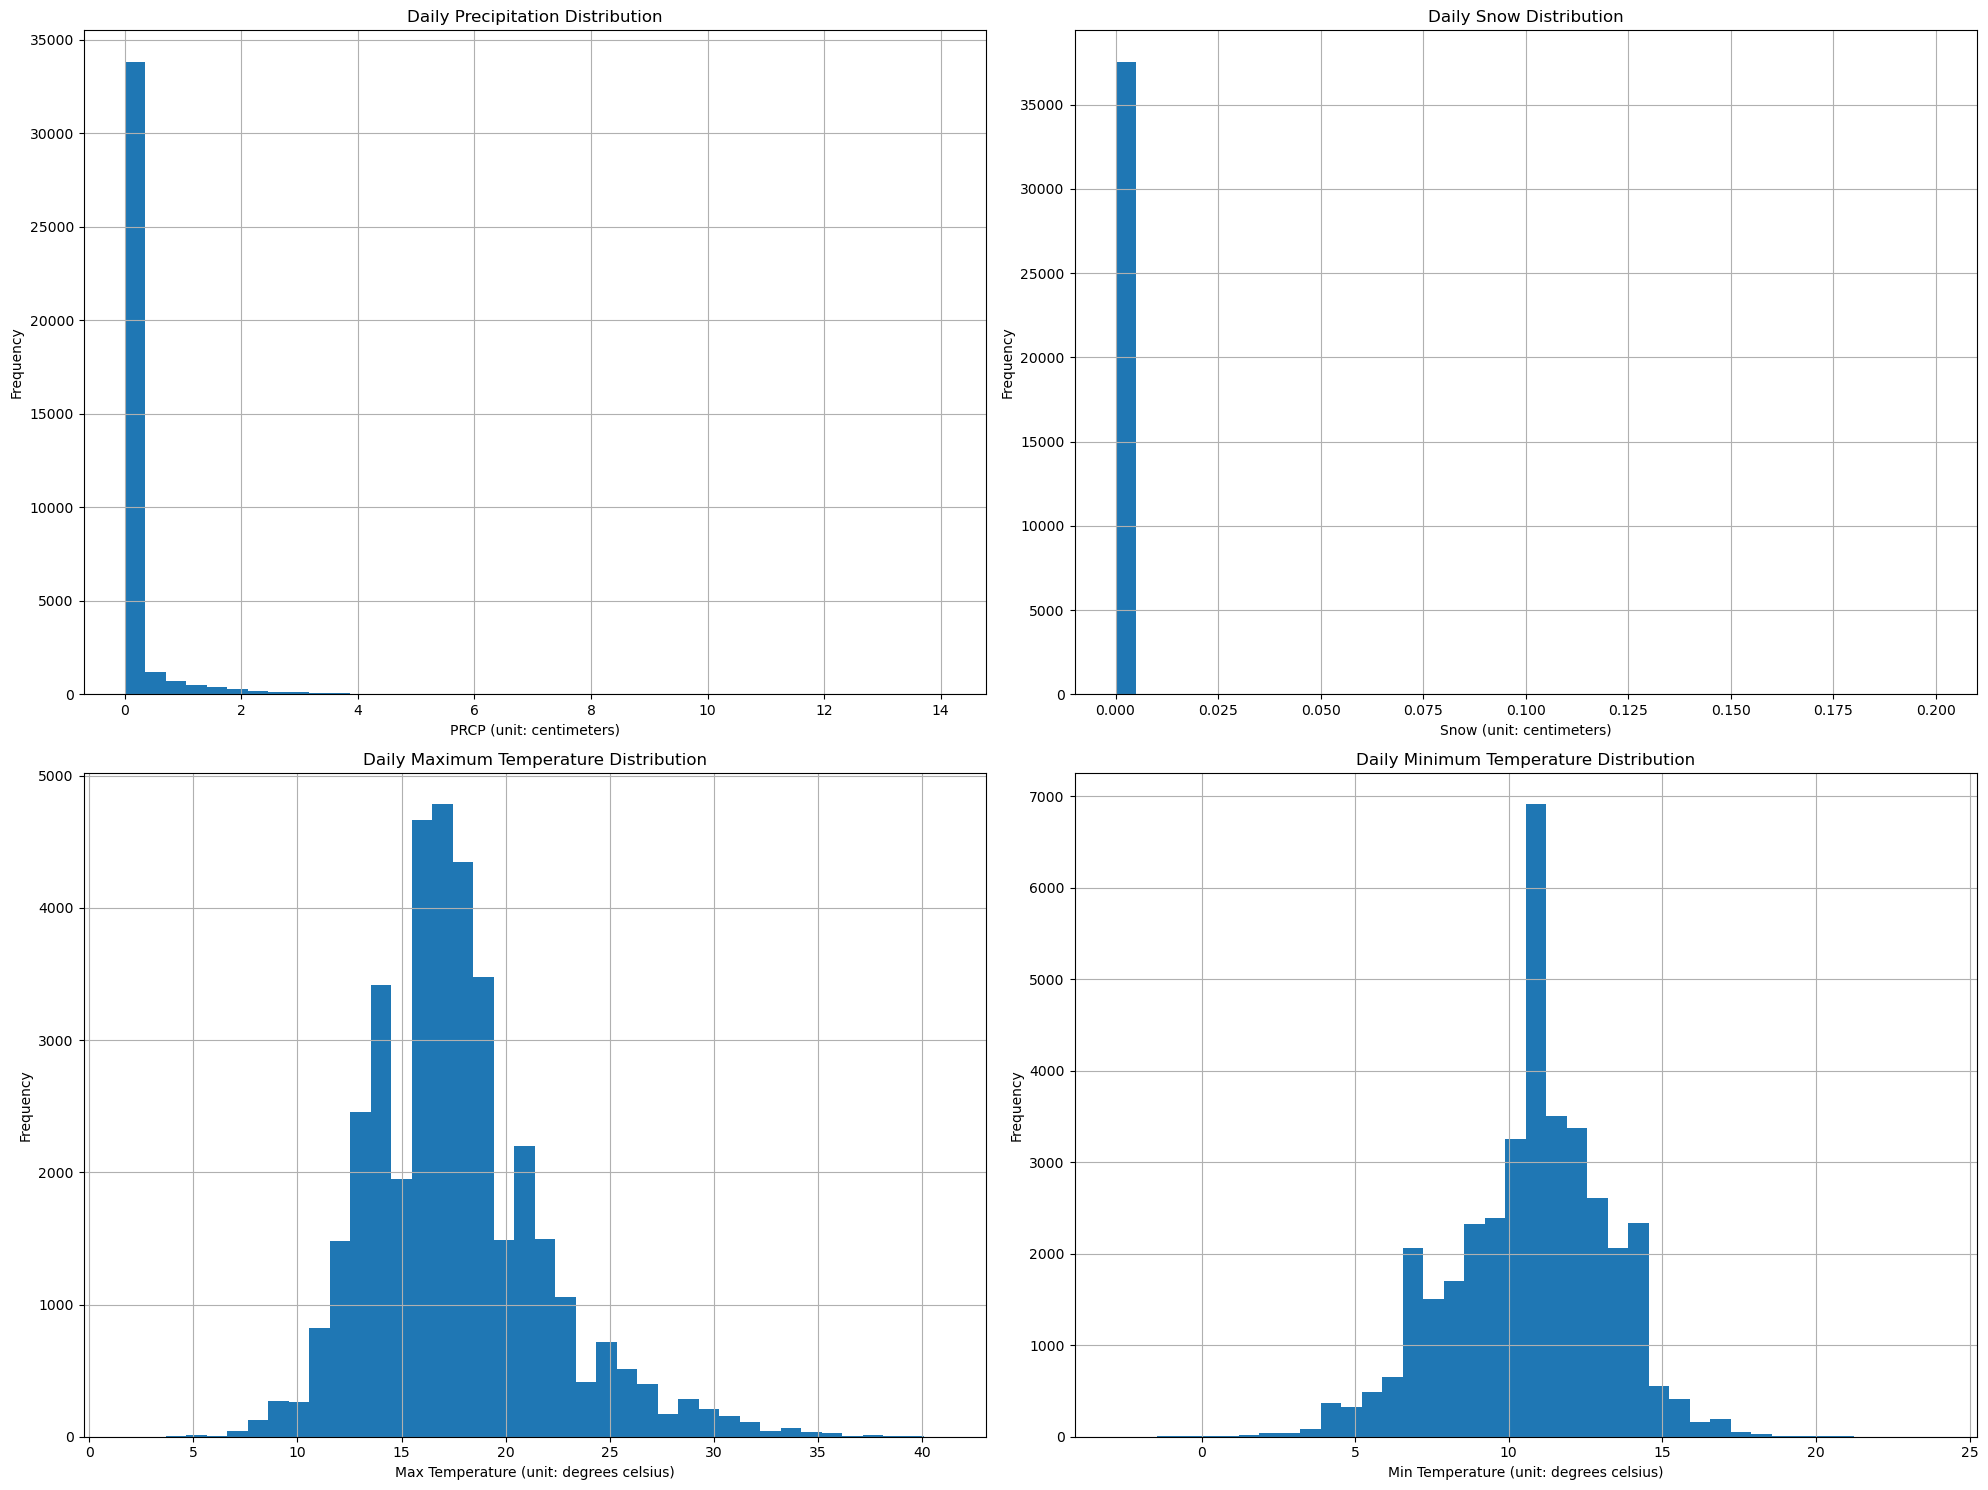

In [46]:
# EDA plot the distributions for the variable and checking for outliers
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

main4['prcp'].hist(bins=40, ax=axes[0, 0])
axes[0, 0].set_title('Daily Precipitation Distribution')
axes[0, 0].set_xlabel('PRCP (unit: centimeters)')
axes[0, 0].set_ylabel('Frequency')

main4['snow'].hist(bins=40, ax=axes[0, 1])
axes[0, 1].set_title('Daily Snow Distribution')
axes[0, 1].set_xlabel('Snow (unit: centimeters)')
axes[0, 1].set_ylabel('Frequency')

main4['tmax'].hist(bins=40, ax=axes[1, 0])
axes[1, 0].set_title('Daily Maximum Temperature Distribution')
axes[1, 0].set_xlabel('Max Temperature (unit: degrees celsius)')
axes[1, 0].set_ylabel('Frequency')

main4['tmin'].hist(bins=40, ax=axes[1, 1])
axes[1, 1].set_title('Daily Minimum Temperature Distribution')
axes[1, 1].set_xlabel('Min Temperature (unit: degrees celsius)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

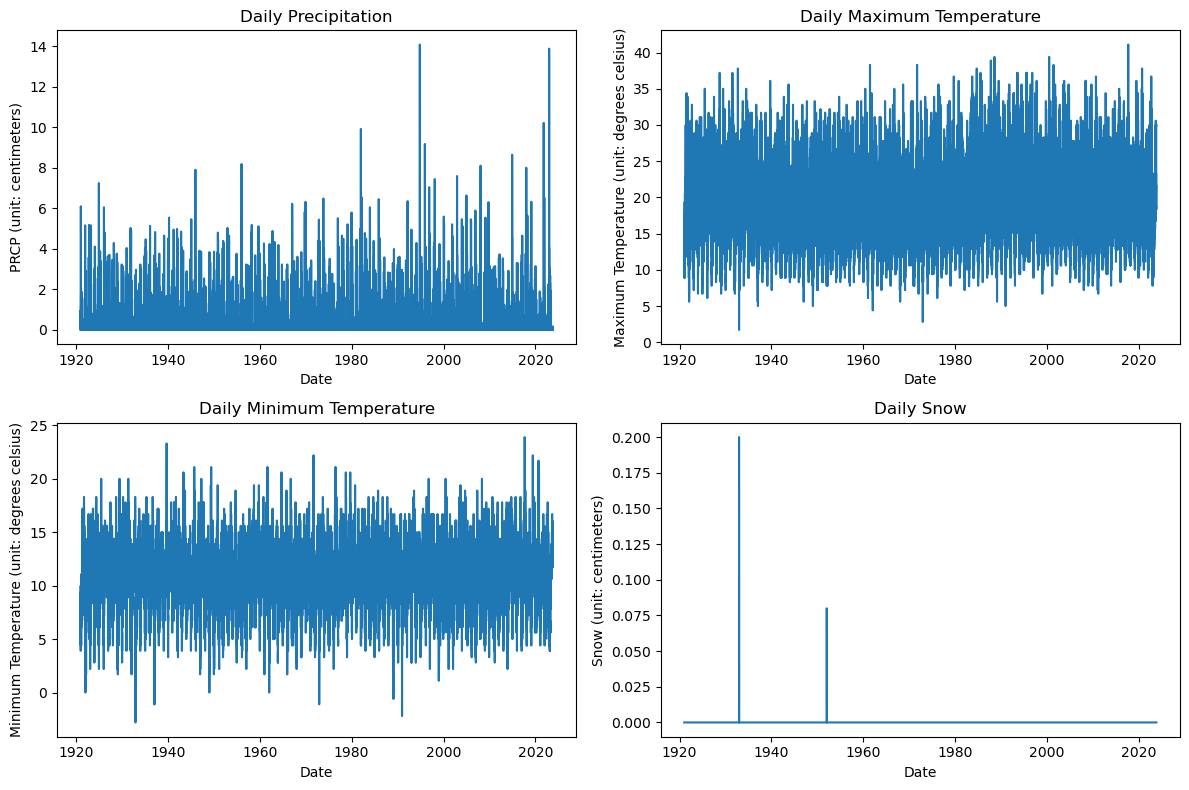

In [47]:
# Convert the date column to datetime format (if not already)
main4['date'] = pd.to_datetime(main4['date'])

# Plot "prcp" in the first chart
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(main4['date'], main4["prcp"])
plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('PRCP (unit: centimeters)')

# Plot "tmax" in the second chart
plt.subplot(2, 2, 2)
plt.plot(main4['date'], main4["tmax"])
plt.title('Daily Maximum Temperature')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (unit: degrees celsius)')

# Plot "tmin" in the third chart
plt.subplot(2, 2, 3)
plt.plot(main4['date'], main4["tmin"])
plt.title('Daily Minimum Temperature')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature (unit: degrees celsius)')

# Plot "snow" in the fourth chart
plt.subplot(2, 2, 4)
plt.plot(main4['date'], main4["snow"])
plt.title('Daily Snow')
plt.xlabel('Date')
plt.ylabel('Snow (unit: centimeters)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [48]:
# create correlation matrix
main4.corr()

,date,prcp,snow,tmax,tmin
date,1.000000,0.007981,-0.007686,0.076755,0.061054
prcp,0.007981,1.000000,0.002021,-0.207540,-0.084355
snow,-0.007686,0.002021,1.000000,-0.020710,-0.029158
tmax,0.076755,-0.207540,-0.020710,1.000000,0.700709
tmin,0.061054,-0.084355,-0.029158,0.700709,1.000000


In [56]:
# Read the Excel file into a pandas DataFrame
rcp = pd.read_excel(file_path)

# Convert the 'rcp' column to datetime
rcp['year'] = pd.to_datetime(rcp['year'], format='%Y')

# Set the 'year' column as the index
# rcp.set_index('year', inplace=True)
rcp.describe()

,year,rcp45,rcp85
count,336,336.000000,336.000000
mean,1932-07-02 12:17:08.571428608,357.274641,412.684412
min,1765-01-01 00:00:00,277.014670,277.014670
25%,1848-10-01 12:00:00,283.907327,283.907327
50%,1932-07-02 00:00:00,299.766810,299.766810
75%,2016-04-01 12:00:00,410.473622,413.634325
max,2100-01-01 00:00:00,580.909450,1231.445300
std,NaN,105.090427,230.931567


In [43]:
# check missing value in rcp
missing_indices = rcp.loc[rcp['rcp45'].isnull()|rcp['rcp85'].isnull()].index
missing_indices

Index([], dtype='int64')

C:\Users\jeng_\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jeng_\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jeng_\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jeng_\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

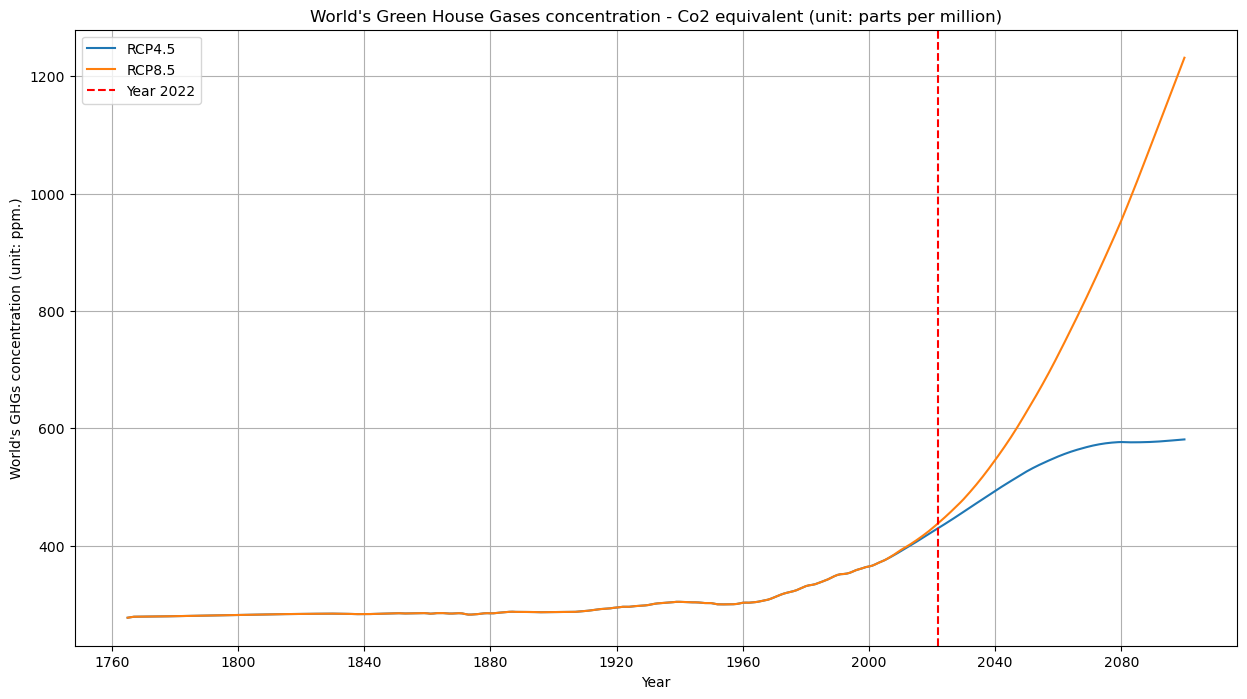

In [57]:
# Assuming 'rcp45' and 'rcp85' have datetime indices after the operations you've performed
plt.figure(figsize=(15, 8))

# Plotting both series on the same chart
sns.lineplot(x='year', y='rcp45', data=rcp, label='RCP4.5')
sns.lineplot(x='year', y='rcp85', data=rcp, label='RCP8.5')
plt.axvline(x=pd.to_datetime('2022'), color='red', linestyle='--', label='Year 2022')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('World\'s GHGs concentration (unit: ppm.)')

plt.title('World\'s Green House Gases concentration - Co2 equivalent (unit: parts per million)')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Create a new column 'decade' to group by every 10 years
main4['decade'] = main4['date'].dt.year // 10 * 10

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'decade' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby('decade')[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Print or use the 'result' DataFrame as needed
print(result)


    decade  prcp_mean  prcp_std  prcp_<lambda_0>  prcp_<lambda_1>  tmax_mean  \
0     1920   0.139048  0.534432              0.0          1.75000  17.633922   
1     1930   0.130764  0.477206              0.0          1.68000  17.714294   
2     1940   0.154769  0.544727              0.0          1.82100  16.933616   
3     1950   0.148458  0.543736              0.0          1.84450  17.008598   
4     1960   0.135374  0.492818              0.0          1.56400  16.812702   
5     1970   0.136383  0.511349              0.0          1.63000  16.905696   
6     1980   0.159338  0.581755              0.0          1.93000  18.422009   
7     1990   0.168831  0.622786              0.0          1.96625  19.013554   
8     2000   0.163479  0.585024              0.0          1.80000  17.833315   
9     2010   0.149351  0.538881              0.0          1.92500  17.914434   
10    2020   0.123369  0.620400              0.0          1.50750  17.781169   

    tmax_std  tmax_<lambda_0>  tmax_<la

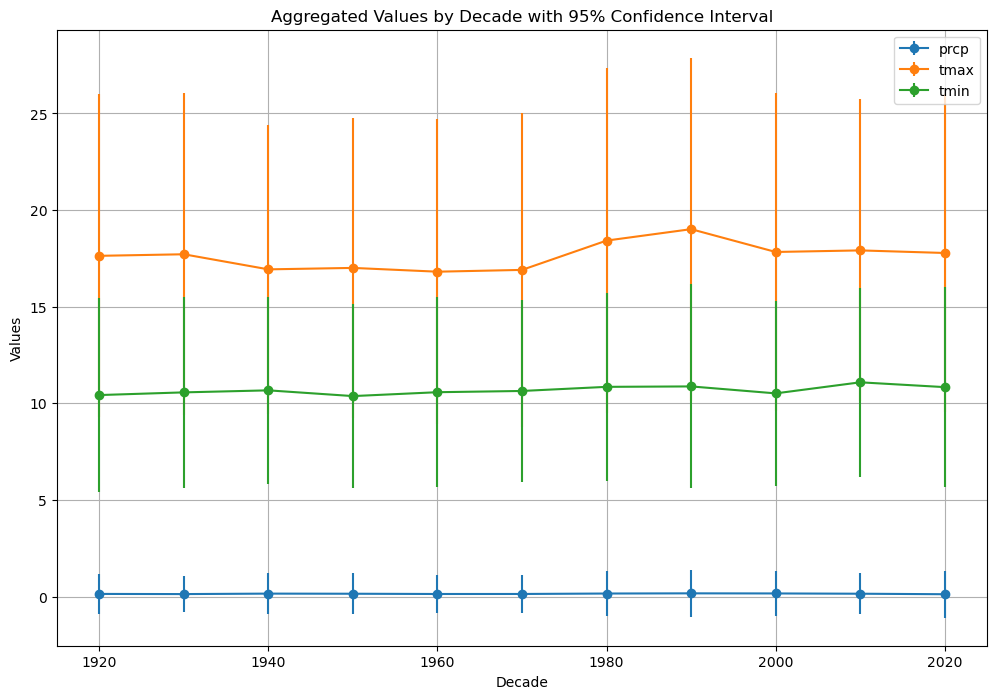

In [62]:
# Assuming 'result' is the DataFrame with aggregated values by decade
# Plotting mean with 95% confidence interval as error bars
plt.figure(figsize=(12, 8))
for col in columns_to_aggregate:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    plt.errorbar(result['decade'], result[mean_col], yerr=1.96 * result[std_col], label=col, marker='o')

# Adding labels and title
plt.xlabel('Decade')
plt.ylabel('Values')
plt.title('Aggregated Values by Decade with 95% Confidence Interval')
plt.legend()
plt.grid(True)import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'date' is a string column in your DataFrame in the format '%y-%m-%d'
main4['date'] = pd.to_datetime(main4['date'], format='%y-%m-%d')

# Create a new column 'decade' to group by every 10 years
main4['decade'] = (main4['date'].dt.year - 1921) // 10 * 10 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'decade' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby('decade')[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval as error bars
plt.figure(figsize=(12, 8))
for col in columns_to_aggregate:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    plt.errorbar(result['decade'], result[mean_col], yerr=1.96 * result[std_col], label=col, marker='o')

# Adding labels and title
plt.xlabel('Decade')
plt.ylabel('Values')
plt.title('Aggregated Values by Decade with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

plt.show()

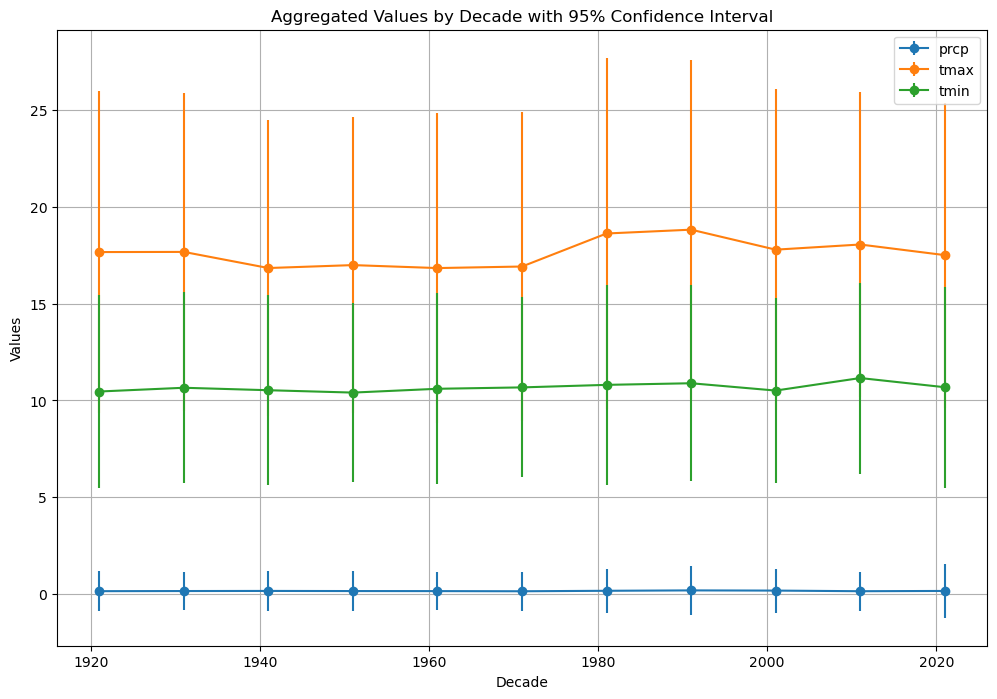

In [64]:

# Create a new column 'decade' to group by every 10 years
main4['decade'] = (main4['date'].dt.year - 1921) // 10 * 10 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'decade' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby('decade')[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval as error bars
plt.figure(figsize=(12, 8))
for col in columns_to_aggregate:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    plt.errorbar(result['decade'], result[mean_col], yerr=1.96 * result[std_col], label=col, marker='o')

# Adding labels and title
plt.xlabel('Decade')
plt.ylabel('Values')
plt.title('Aggregated Values by Decade with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


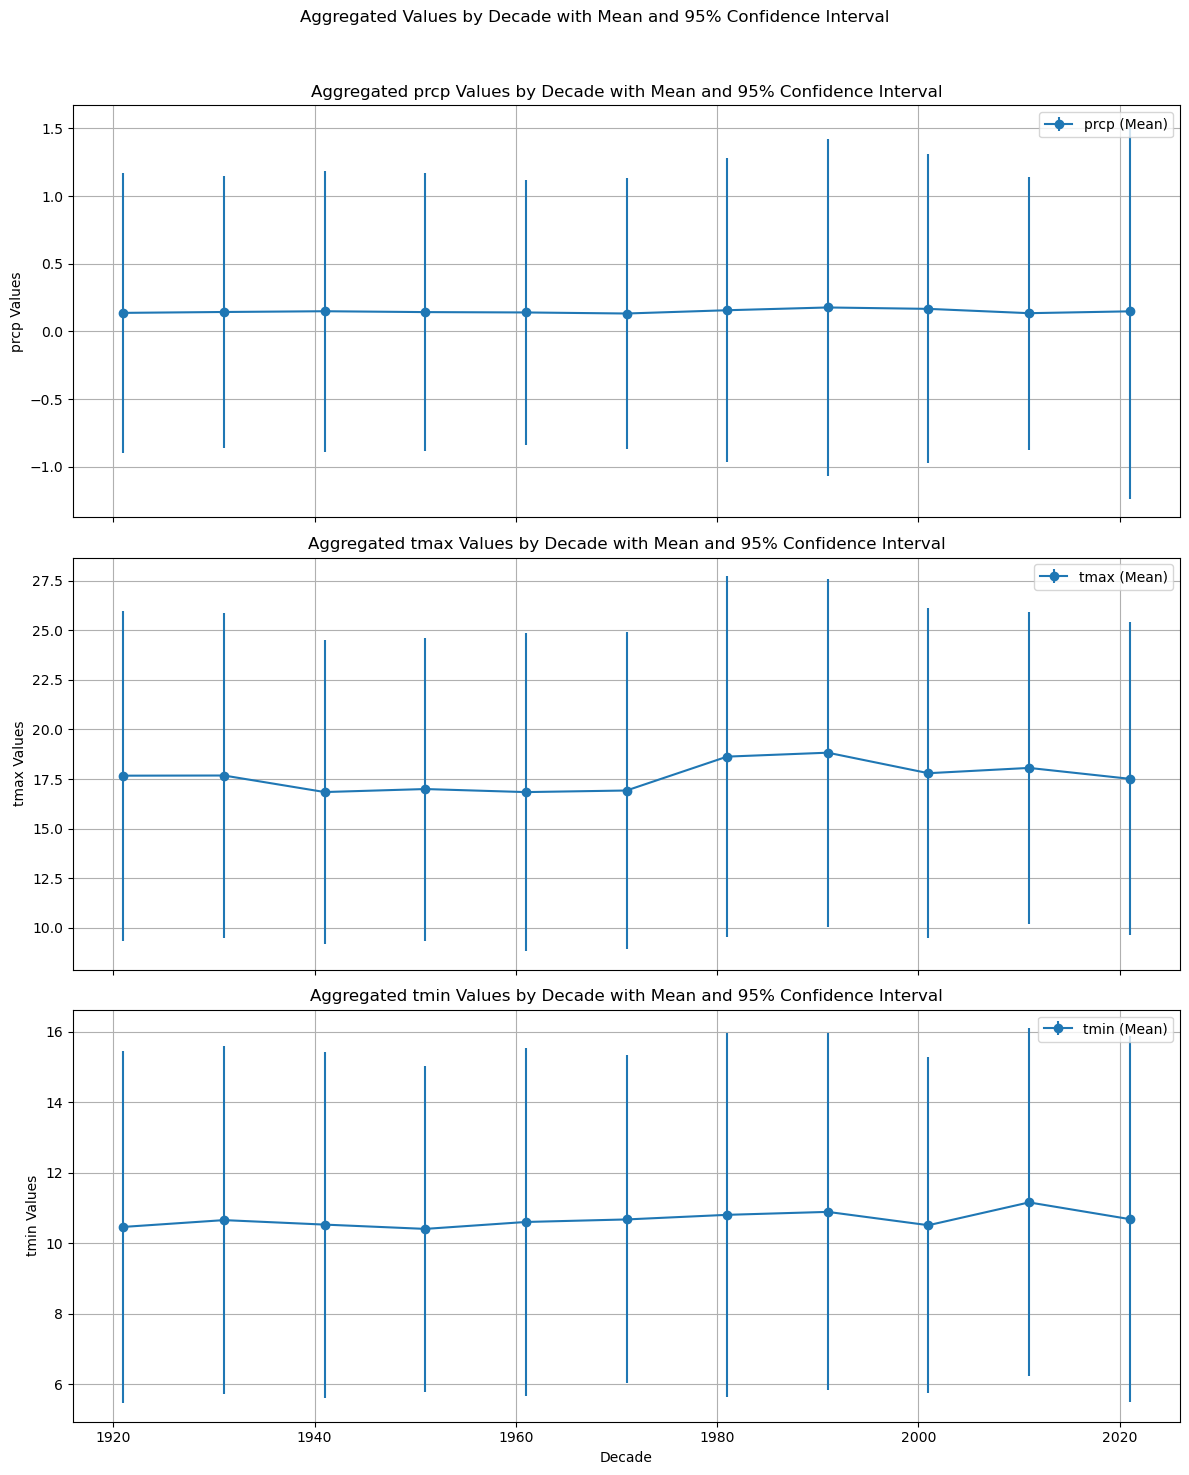

In [66]:

# Create a new column 'decade' to group by every 10 years
main4['decade'] = (main4['date'].dt.year - 1921) // 10 * 10 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'decade' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby(['decade'])[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval as error bars for each variable
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

for i, col in enumerate(columns_to_aggregate):
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    
    # Plotting mean with 95% confidence interval as error bars
    axes[i].errorbar(result['decade'],
                     result[mean_col],
                     yerr=1.96 * result[std_col],
                     label=f"{col} (Mean)",
                     marker='o')
    
    # Adding labels and title for each subplot
    axes[i].set_ylabel(f'{col} Values')
    axes[i].set_title(f'Aggregated {col} Values by Decade with Mean and 95% Confidence Interval')
    axes[i].legend()
    axes[i].grid(True)

# Adding labels and title for the entire figure
plt.xlabel('Decade')
plt.suptitle('Aggregated Values by Decade with Mean and 95% Confidence Interval')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout for the suptitle
plt.show()


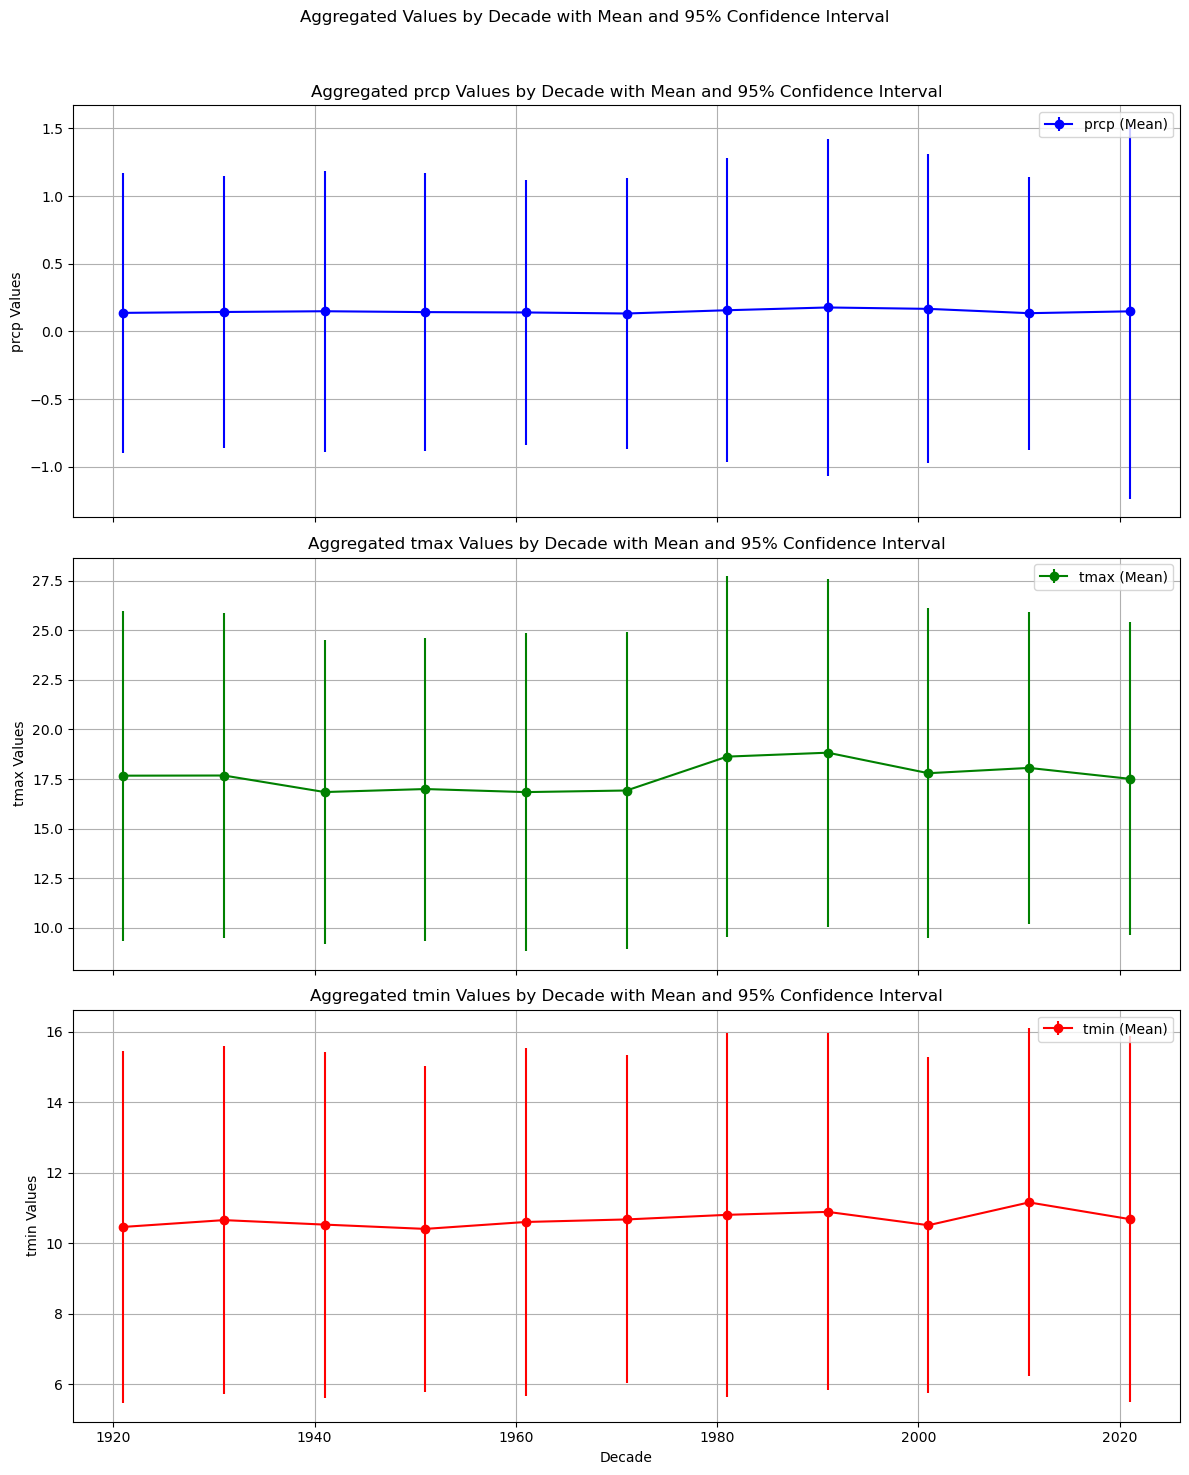

In [67]:
# Create a new column 'decade' to group by every 10 years
main4['decade'] = (main4['date'].dt.year - 1921) // 10 * 10 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'decade' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby(['decade'])[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Define colors for each series
colors = {'prcp': 'blue', 'tmax': 'green', 'tmin': 'red'}

# Plotting mean with 95% confidence interval as error bars for each variable
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

for i, col in enumerate(columns_to_aggregate):
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    
    # Plotting mean with 95% confidence interval as error bars
    axes[i].errorbar(result['decade'],
                     result[mean_col],
                     yerr=1.96 * result[std_col],
                     label=f"{col} (Mean)",
                     marker='o',
                     color=colors[col])
    
    # Adding labels and title for each subplot
    axes[i].set_ylabel(f'{col} Values')
    axes[i].set_title(f'Aggregated {col} Values by Decade with Mean and 95% Confidence Interval')
    axes[i].legend()
    axes[i].grid(True)

# Adding labels and title for the entire figure
plt.xlabel('Decade')
plt.suptitle('Aggregated Values by Decade with Mean and 95% Confidence Interval')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout for the suptitle
plt.show()


In [63]:

# Create a new column 'half_century' to group by every 50 years
main4['half_century'] = (main4['date'].dt.year - 1921) // 50 * 50 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'half_century' and calculate mean and 95% confidence interval
result = main4.groupby(['half_century', 'variable'])[columns_to_aggregate].agg(['mean', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval for each series
for col in columns_to_aggregate:
    plt.figure(figsize=(12, 8))
    
    mean_col = f"{col}_mean"
    lower_bound_col = f"{col}_<lambda_0>"
    upper_bound_col = f"{col}_<lambda_1>"

    # Plotting mean with 95% confidence interval as error bars
    plt.errorbar(result[result['variable'] == col]['half_century'],
                 result[result['variable'] == col][mean_col],
                 yerr=[result[result['variable'] == col][mean_col] - result[result['variable'] == col][lower_bound_col],
                       result[result['variable'] == col][upper_bound_col] - result[result['variable'] == col][mean_col]],
                 label=f"{col} (Mean)",
                 marker='o')
    
    # Adding labels and title
    plt.xlabel('Half Century')
    plt.ylabel('Values')
    plt.title(f'Aggregated Values for {col} with Mean and 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.show()


KeyError: 'variable'

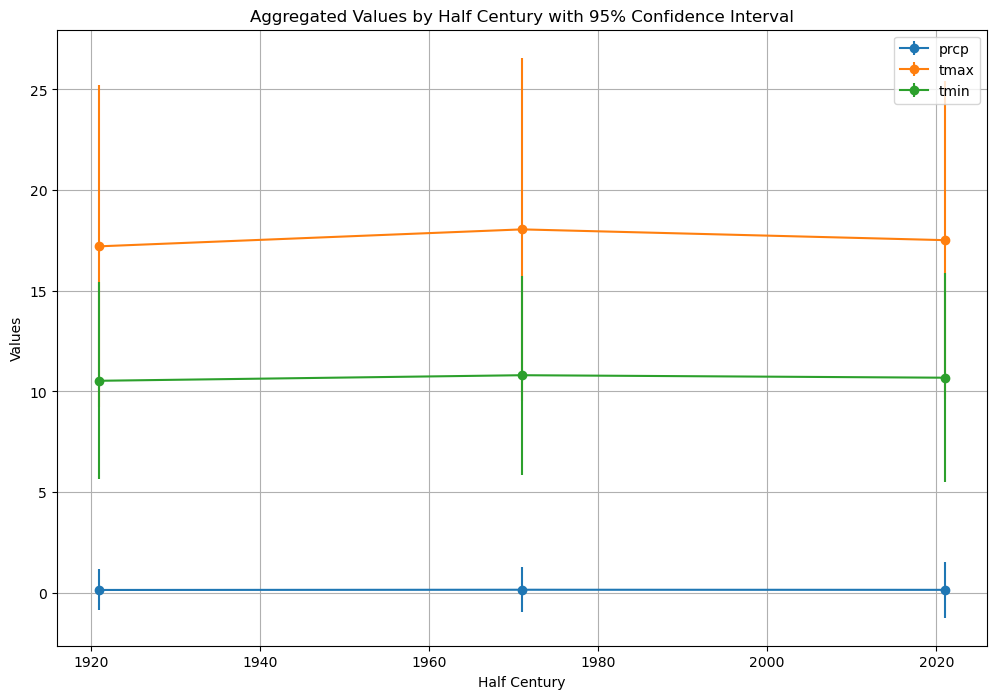

In [52]:
# Create a new column 'half_century' to group by every 50 years
main4['half_century'] = (main4['date'].dt.year - 1921) // 50 * 50 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'half_century' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby('half_century')[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval as error bars
plt.figure(figsize=(12, 8))
for col in columns_to_aggregate:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    plt.errorbar(result['half_century'], result[mean_col], yerr=1.96 * result[std_col], label=col, marker='o')

# Adding labels and title
plt.xlabel('Half Century')
plt.ylabel('Values')
plt.title('Aggregated Values by Half Century with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


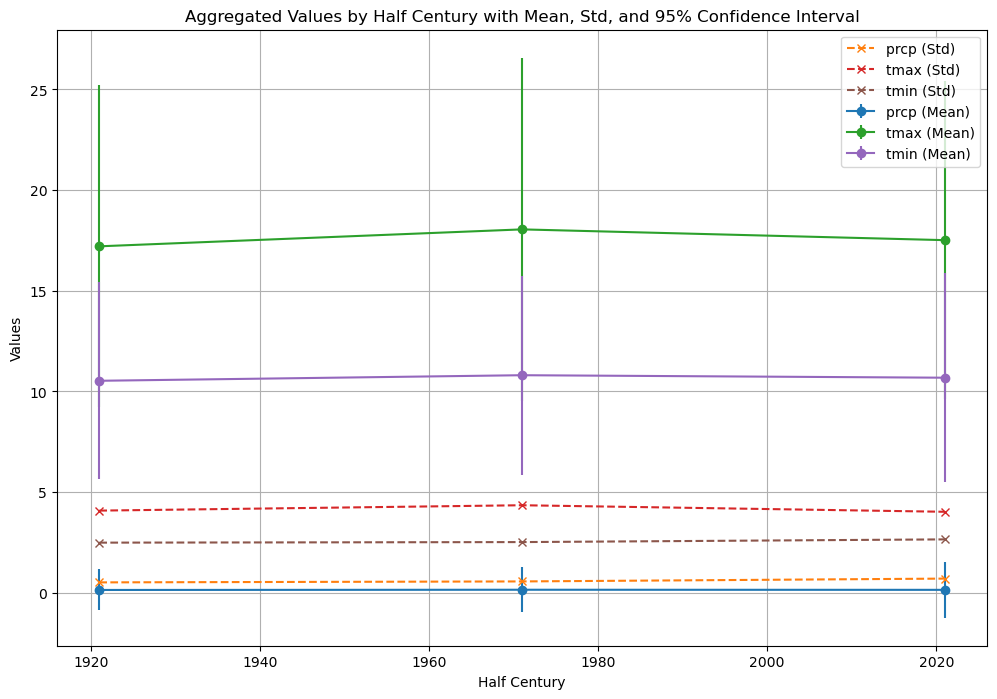

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'date' is a string column in your DataFrame in the format '%y-%m-%d'
main4['date'] = pd.to_datetime(main4['date'], format='%y-%m-%d')

# Create a new column 'half_century' to group by every 50 years
main4['half_century'] = (main4['date'].dt.year - 1921) // 50 * 50 + 1921

# Define the columns to aggregate
columns_to_aggregate = ['prcp', 'tmax', 'tmin']

# Group by 'half_century' and calculate mean, standard deviation, and 95% confidence interval
result = main4.groupby('half_century')[columns_to_aggregate].agg(['mean', 'std', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])

# Rename the columns for better clarity
result.columns = [f"{col}_{agg}" for col, agg in result.columns]

# Reset the index for a flat DataFrame
result.reset_index(inplace=True)

# Plotting mean with 95% confidence interval and standard deviation
plt.figure(figsize=(12, 8))
for col in columns_to_aggregate:
    mean_col = f"{col}_mean"
    std_col = f"{col}_std"
    
    # Plotting mean with 95% confidence interval as error bars
    plt.errorbar(result['half_century'], result[mean_col], yerr=1.96 * result[std_col], label=f"{col} (Mean)", marker='o')
    
    # Plotting standard deviation as a separate line
    plt.plot(result['half_century'], result[std_col], label=f"{col} (Std)", linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Half Century')
plt.ylabel('Values')
plt.title('Aggregated Values by Half Century with Mean, Std, and 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()



**Feature engineering**

In [9]:
# generate training set for time series data
# assign 'date' with 'precipitation' series
data = prcp.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # Adjust as needed
X, y = create_sequences(data_normalized, seq_length)

**Preparing Data for Training and Testing**

We split the dataset from 1920 to 2023, roughly 102 years of daily precipitation, into 82 years of training and the last 20 years of testing sets to evaluate the model's performance. We use the last 20 years as the testing for two reasons: (1) to evaluate the models’ performances in the long term, and (2) we want to forecast the last 20 years 
As you see in EDA section, our data set has just a few missing data, 12 missing data from 37,544, we use linear interpolation to fill in the missing data. Then we normalized the data with Min-Max scaling before modeling.


In [10]:
# Reshape X to 2D array
X_reshaped = X.reshape(X.shape[0], -1)

# Reshape y to 1D array
y_reshaped = y[:, 0, 0]  # Assuming y has shape (num_samples, 1, 1)
y_reshaped.shape
X_train =X_reshaped[:30209,:]
X_test =X_reshaped[30209:,:]
y_train =y_reshaped[:30209]
y_test =y_reshaped[30209:]

**Choosing the Models**

To address these special features of climate change's impact on precipitation, the literatures suggested Neural network models such as Long Short-Term Memory (LSTM) or other types of recurrent neural networks with a training set that includes a long enough past daily precipitations, for example, a cycle of El Nino and La Nina is roughly 10 years. We have tried LSTM but have not succeeded because of not enough computing power (you can see the code in the last cell.) In fact, we can only implement the models (including hyperparameter tuning) using the past 30 days' information to forecast the next day due to the same reason.
The model we implemented are:
1. Ridge Regression: the regression with L2 regularlization
2. ARIMA: AutoRegressive Integrated Moving Average is a popular time series forecasting method that combines autoregression (AR) and moving average (MA) components. The "integrated" part refers to differencing, a step used to make the time series stationary
3. XGBoost: XGBoost is a powerful and efficient machine learning algorithm that belongs to the class of ensemble learning methods, specifically gradient boosting. It has gained popularity for its exceptional predictive performance in various machine learning competitions and real-world applications.

**Based on MSE in the test, the XGBoost is the best model, it has MSE = 0.001435 lower than 0.03831 and 0.0017479, of Ridge Regression and ARIMA, respectively.**

**Ridge regression model**

**hyperparameter**

The provided grid includes different values for each hyperparameter. During hyperparameter tuning, the model will be trained and evaluated using different combinations of these hyperparameter values. The goal is to find the combination that results in the best model performance, often measured using mean squared error. The following are hyperparameters: 

    1)alpha: Ridge Regression introduces a regularization term proportional to the square of the coefficients. The alpha parameter controls the strength of this regularization. The grid search is considering values from 0.1 to 0.9 in increments of 0.1.
    2)fit_intercept: This is a boolean parameter that indicates whether to calculate the intercept for this model. The grid search is considering both True and False as options.
    3)solver: Ridge Regression can be solved using different algorithms, and the solver parameter determines which one to use. The grid search is considering four options: 'auto', 'svd', 'cholesky', and 'lsqr'.

In [27]:
# Ridge regression model
#-----------
#import libraries
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# create function to calculate the root mean squared errror
def mse(pred, actual):
    return np.mean((pred - actual) ** 2)

# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5)       # 5-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on training set 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_train)   # find best estimator and predict on training

# Ridge model using the test dataset and the trained model, predict
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_test)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Ridge Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Ridge Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Ridge Validation MSE', rmse(best_ridge_pred, y_test))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'}
Ridge Best CV R^2: 0.11707577458561721
Ridge Validation R^2: 0.10596755860389406
Ridge Validation MSE 0.03831704483774142


**ARIMA Model**

**The Order (p, d, q) for ARIMA**
The order tuple specifies the parameters of the ARIMA model. The three components are:

    p (order of the autoregressive part) =20 : This is the number of lag observations included in the model.
    d (degree of differencing)=1: This is the number of times that the raw observations are differenced. In this case, d=1d=1 suggests that first differences are taken.
    qq (order of the moving average part) =20: This is the size of the moving average window.


In [20]:
#!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have a univariate time series
y_train = pd.Series(y_train)

# Choose the order (p, d, q) for ARIMA. You may need to tune these values.
order = (20, 1, 20)  # Replace p, d, q with appropriate values

# Train ARIMA model
model = ARIMA(y_train, order=order)
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

# Get the residuals
#residuals = pd.DataFrame(model_fit.resid)

# Plot residuals to check for patterns
#residuals.plot()
#plt.show()

# Forecast on the test set
y_pred = model_fit.forecast(steps=len(y_test))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

"""
# Plot the actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
"""

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30209
Model:               ARIMA(20, 1, 20)   Log Likelihood               57439.089
Date:                Mon, 27 Nov 2023   AIC                        -114796.179
Time:                        20:31:35   BIC                        -114455.228
Sample:                             0   HQIC                       -114686.817
                              - 30209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6983      1.058     -0.660      0.509      -2.772       1.375
ar.L2         -0.5355      1.396     -0.384      0.701      -3.271       2.200
ar.L3         -0.5690      1.103     -0.516      0.6

"\n# Plot the actual vs predicted values\nplt.plot(y_test, label='Actual')\nplt.plot(y_pred, label='Predicted')\nplt.legend()\nplt.show()\n"

**XGboost Model**

**hyperparameter**

The provided grid includes different values for each hyperparameter. During hyperparameter tuning, the model will be trained and evaluated using different combinations of these hyperparameter values. The goal is to find the combination that results in the best model performance, often measured using mean squared error. The following are hyperparameters: 

    n_estimators: This hyperparameter represents the number of trees in the model. It is the number of boosting rounds to be run.

    learning_rate: This is the step size shrinkage used to prevent overfitting. It scales the contribution of each tree.

    max_depth: The maximum depth of a tree. It controls the maximum depth of each tree in the ensemble.

    subsample: This is the fraction of samples used for fitting the individual base learners. It controls the subsampling of the training dataset.

    colsample_bytree: This is the fraction of features used for fitting the individual base learners. It controls the subsampling of the features.

In [11]:
# import libraries for xgboost
#!pip install xgboost
import time
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# record the start time
start_time = time.time()

# initialize an xgb regressor
xgb_regressor = xgb.XGBRegressor(random_state=10)

# define a hyperparameter grid
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# perform grid search with time series cross-validation
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# use the best parameters to train the final model
final_model_xgb = xgb.XGBRegressor(random_state=10, **best_params)
final_model_xgb.fit(X_train, y_train)

# make predictions on the test set
y_pred = final_model_xgb.predict(X_test)

# evaluate the final model using appropriate metrics for regression
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# print the best hyperparameters and metrics
print(f"Best Hyperparameters: {best_params}")
print(f"\nMean Squared Error: {mse} \nMean Absolute Error: {mae}")
print(f"\nRuntime: {time.time() - start_time} seconds")

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}

Mean Squared Error: 0.0014351283049242923 
Mean Absolute Error: 0.014582961913706227

Runtime: 438.43178725242615 seconds


**LSTM code**

In [49]:
"""
LSTM code
# import libraries
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip show tensorflow
#!pip install --user tensorflow
#!pip install tensorflow==2.13.1
#!pip install --upgrade scikit-learn
#!pip install keras==2.12.1
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import categorical_crossentropy
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# assign 'date' with 'precipitation' series
data = prcp.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # Adjust as needed
X, y = create_sequences(data_normalized, seq_length)

# Assuming 'X' and 'y' are your input features and target variable
# Assuming 'seq_length' is your sequence length

# Function to create an LSTM model
def create_lstm_model(units=50, optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Normalize the data
#scaler = MinMaxScaler()
#X_normalized = scaler.fit_transform(X.reshape(-1, 1))

# Reshape X for LSTM input
X_reshaped = X.reshape((X.shape[0], seq_length, 1))

# Create KerasRegressor wrapper for scikit-learn
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32, verbose=0)

# Define hyperparameters to search over
param_grid = {
    'units': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3]
}

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Create GridSearchCV
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

# Fit the model
grid_result = grid.fit(X_reshaped, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
"""

'\nLSTM code\n# import libraries\n#!pip install tensorflow\n#!pip install --upgrade tensorflow\n#!pip install --upgrade keras\n#!pip show tensorflow\n#!pip install --user tensorflow\n#!pip install tensorflow==2.13.1\n#!pip install --upgrade scikit-learn\n#!pip install keras==2.12.1\nimport numpy as np\nimport pandas as pd\n%matplotlib inline\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.preprocessing import MinMaxScaler\nfrom tensorflow.keras.losses import categorical_crossentropy\n#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor\n# assign \'date\' with \'precipitation\' series\ndata = prcp.values.reshape(-1, 1)\n\n# Normalize the data\nscaler = MinMaxScaler()\ndata_normalized = scaler.fit_transform(data)\n\n# Prepare data for LSTM\ndef create_sequences(data, seq_length):\n    sequen

**Understanding the Machine Learning Problem**

The type of machine learning problem we are investigating is an univariate time series forecasting model with a continuous variable (daily precipitation.) Climate change's impact on precipitation has special features that make it hard to model - its impact is stochastic and slowly transmits its impact in the long term, more than 20 years.

